# Check on the files exported by Equivital File Manager
Plot and review measurements from equivital sensors as output by the Equivital Manager app.
(Every program produces different formated files and it's a pain.)

In [4]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.signal import butter,filtfilt
from scipy import interpolate
from scipy.interpolate import interp1d

In [5]:
%load_ext autoreload
%autoreload 1
%aimport qex

## Definitions for data extraction

In [13]:
def min_dets(eq_file_loc): # for files output by the lab manager desktop app, so far
    filings = eq_file_loc.split('\\')
    file_name = filings[-1]
    f = file_name.split('.')
    sig = f[-2][9:]
    
    if len(file_name.split(' '))==2:
        fileDate = file_name.split(' ')[0]
        Session = 'NA'
    else:
        fileDate = file_name.split('_')[0][:6]
        Session = file_name.split('_')[0][7:]
        
    if len(f[-2][9:].split('('))==2:
        sig = f[-2][9:].split('(')[0]
    
    File_dets={'Signal':sig, #f[-2].split('_')[-1],
       'ID':filings[-2], 
       'Date':fileDate ,
       'Session':Session,
       'FileName':file_name,
       'FileType':f[-1],
       'FullLoc':eq_file_loc}
    return File_dets

def eq_file_exct(eq_file_loc): # Files output by labManager
    dets=min_dets(eq_file_loc)
    #print(dets)
    V = pd.read_csv(eq_file_loc,skipinitialspace=True)
    # Extract according to signal type
    cols = list(V.columns )
    # find time colums
    time_c = [x for x in cols if x.lower().startswith('time')]
    if len(V.loc[0,'Date (M/d/yyyy)'])<20:
        V.loc[:,'Time'] = pd.to_datetime(V.loc[:,'Date (M/d/yyyy)'],format='%m/%d/%Y')+ pd.to_timedelta(V.loc[:,time_c[0]]) 
        cols.remove('Date (M/d/yyyy)')    
        cols.remove(time_c[0])
        sig_df = pd.DataFrame(index = V.loc[:,'Time'],
                 columns = cols,
                 data = V.loc[:,cols].values)
    else:
        print('No Signal')
        sig_df = pd.DataFrame()
    return sig_df


In [35]:
# should convert for types and not change names of columns? .astype(float)

def eq_file_exct(eq_file_loc): # Files output by labManager
    dets=min_dets(eq_file_loc)
    #print(dets)
    V = pd.read_csv(eq_file_loc,skipinitialspace=True)
    print(V.iloc[0,:])
    # Extract according to signal type
    cols = V.columns 
    if dets['Signal'] in ['Indications','NewSummary']:
    #'Date (M/d/yyyy)', 'Time (HH:mm:ss.000)', 'Inter Beat Interval (ms)'
        V.loc[:,'Time'] = pd.to_datetime(V.loc[:,'Date (M/d/yyyy)']+ ' ' + V.loc[:,'Time (HH:mm:ss)']) 
        cols.drop(['Date (M/d/yyyy)','Time (HH:mm:ss)'])
    else:
        V.loc[:,'Time'] = pd.to_datetime(V.loc[:,'Date (M/d/yyyy)']+ ' ' + V.loc[:,'Time (HH:mm:ss.000)']) 
        cols.drop(['Date (M/d/yyyy)','Time (HH:mm:ss.000)'])


    if dets['Signal'] == 'ECGmV':
        sig_df = V.loc[:,['ECG Lead 1', 'ECG Lead 2']].copy()
        sig_df.set_index(pd.to_datetime(V.loc[:,'Time']),inplace=True)
        return sig_df
    if dets['Signal'] == 'Belt':
    # 'Date (M/d/yyyy)', 'Time (HH:mm:ss.000)', 'Breathing Wave'
        V.loc[:,'Breathing'] = V.loc[:,'Breathing Wave'].astype('int64')
        sig_df = V.loc[:,['Breathing']].copy()
        sig_df.set_index(V.loc[:,'Time'],inplace=True)
        return sig_df 
    if dets['Signal'].lower().startswith('acc'): # AccMG and AccmG_HR 
        V.loc[:,'Z'] = V.loc[:,'Vertical Acc']
        V.loc[:,'Y'] = V.loc[:,'Lateral Acc']
        V.loc[:,'X'] = V.loc[:,'Longitudinal Acc']
        sig_df = V.loc[:,['X','Y','Z']].copy()
        sig_df.set_index(V.loc[:,'Time'],inplace=True)
        return sig_df 
    if dets['Signal'] == 'Indications': # 'HR Confidence', 'BR Confidence']
        V.loc[:,'HR Confidence'] = V.loc[:,'HR Confidence']
        V.loc[:,'BR Confidence'] = V.loc[:,'BR Confidence']
        sig_df = V.loc[:,['HR Confidence', 'BR Confidence']].copy()
        sig_df.set_index(V.loc[:,'Time'],inplace=True)
        return sig_df         
    if dets['Signal'] == 'NewSummary': # 'HR Confidence', 'BR Confidence']
#         ['Date (M/d/yyyy)', 'Time (HH:mm:ss)', 'Sensor ID',
#        'SEM File Designation', 'HR (bpm)', 'BR (rpm)',
#        'Skin Temperature - IR Thermometer (°C)', 'Body Position',
#        'Ambulation Status', 'Alert', 'PWI', 'Device Indications',
#        'Subject Indications']
        V.loc[:,'HR_bpm'] = V.loc[:,'HR (bpm)']
        V.loc[:,'BR_rpm'] = V.loc[:,'BR (rpm)']
        V.loc[:,'SkinTemp'] = V.loc[:,'Skin Temperature - IR Thermometer (°C)']
        V.loc[:,'Posture'] = V.loc[:,'Body Position']
        V.loc[:,'Ambulation'] = V.loc[:,'Ambulation Status']
        
        sig_df = V.loc[:,['HR_bpm','BR_rpm','SkinTemp','Posture','Ambulation']].copy()
        sig_df.set_index(V.loc[:,'Time'],inplace=True)
        return sig_df 

    else:
        print('Not familiar signal')
        return

# User output test

In [55]:
SEM_OUTPUT_Folder = 'C:\\Users\\fourMs lab\\Documents\\Equivital\\Equivital Manager\\' 

In [56]:
path = SEM_OUTPUT_Folder 
file_locs = []
for root, dirs, files in os.walk(path):
    for file in files:
        if(file.lower().endswith(".csv")):
            file_locs.append(os.path.join(root,file))
            print(file_locs[-1])
k=[]           
for f in file_locs:
    File_dets=min_dets(f)
    k.append(File_dets)
df_files=pd.DataFrame(data=k) #.sort_values('StartTime').reset_index(drop=True)
df_files

C:\Users\fourMs lab\Documents\Equivital\Equivital Manager\03420415\23011802_AccMG.csv
C:\Users\fourMs lab\Documents\Equivital\Equivital Manager\03420415\23011802_AccmG_HR.csv
C:\Users\fourMs lab\Documents\Equivital\Equivital Manager\03420415\23011802_Belt.csv
C:\Users\fourMs lab\Documents\Equivital\Equivital Manager\03420415\23011802_BloodPressure.csv
C:\Users\fourMs lab\Documents\Equivital\Equivital Manager\03420415\23011802_CorePill.csv
C:\Users\fourMs lab\Documents\Equivital\Equivital Manager\03420415\23011802_DermalPatch.csv
C:\Users\fourMs lab\Documents\Equivital\Equivital Manager\03420415\23011802_ECGDerivedBreathing.csv
C:\Users\fourMs lab\Documents\Equivital\Equivital Manager\03420415\23011802_ECGmV.csv
C:\Users\fourMs lab\Documents\Equivital\Equivital Manager\03420415\23011802_EventComments.csv
C:\Users\fourMs lab\Documents\Equivital\Equivital Manager\03420415\23011802_GSR.csv
C:\Users\fourMs lab\Documents\Equivital\Equivital Manager\03420415\23011802_Indications.csv
C:\Users\

,Signal,ID,Date,Session,FileName,FileType,FullLoc
0,AccMG,03420415,230118,2,23011802_AccMG.csv,csv,C:\Users\fourMs lab\Documents\Equivital\Equivi...
1,AccmG_HR,03420415,230118,2,23011802_AccmG_HR.csv,csv,C:\Users\fourMs lab\Documents\Equivital\Equivi...
2,Belt,03420415,230118,2,23011802_Belt.csv,csv,C:\Users\fourMs lab\Documents\Equivital\Equivi...
3,BloodPressure,03420415,230118,2,23011802_BloodPressure.csv,csv,C:\Users\fourMs lab\Documents\Equivital\Equivi...
4,CorePill,03420415,230118,2,23011802_CorePill.csv,csv,C:\Users\fourMs lab\Documents\Equivital\Equivi...
...,...,...,...,...,...,...,...
228,ECGmV,03420755,230120,6,23012006_ECGmV.csv,csv,C:\Users\fourMs lab\Documents\Equivital\Equivi...
229,EventComments,03420755,230120,6,23012006_EventComments.csv,csv,C:\Users\fourMs lab\Documents\Equivital\Equivi...
230,Indications,03420755,230120,6,23012006_Indications.csv,csv,C:\Users\fourMs lab\Documents\Equivital\Equivi...
231,NewSummary,03420755,230120,6,23012006_NewSummary.csv,csv,C:\Users\fourMs lab\Documents\Equivital\Equivi...


In [57]:
# select subset of files from a specific devices
print('Date: ' + str(df_files['Date'].unique()))
print('Session: ' + str(df_files['Session'].unique()))
print('Signal: ' + str(df_files['Signal'].unique()))
datum = '230120' # this is a string of the number on the sensor unite
sub_files=df_files.loc[df_files['Date'] == datum,:]
sub_files

Date: ['230118' '230119' '230120' '230123' '230203' '2023_01_17' '230117']
Session: ['2' '3' '0' '6' '7' '1' 'NA' '4']
Signal: ['AccMG' 'AccmG_HR' 'Belt' 'BloodPressure' 'CorePill' 'DermalPatch'
 'ECGDerivedBreathing' 'ECGmV' 'EventComments' 'GSR' 'Indications'
 'NewSummary' 'OxygenSats' 'PPG' 'RR' '0_AccMG' '0_AccmG_HR' '0_Belt'
 '0_ECGmV' '0_EventComments' '0_Indications' '0_NewSummary' '0_RR' '' 'HR'
 'omments' 'tions' 'mary']


,Signal,ID,Date,Session,FileName,FileType,FullLoc
62,AccMG,03420415,230120,6,23012006_AccMG.csv,csv,C:\Users\fourMs lab\Documents\Equivital\Equivi...
63,AccmG_HR,03420415,230120,6,23012006_AccmG_HR.csv,csv,C:\Users\fourMs lab\Documents\Equivital\Equivi...
64,Belt,03420415,230120,6,23012006_Belt.csv,csv,C:\Users\fourMs lab\Documents\Equivital\Equivi...
65,ECGmV,03420415,230120,6,23012006_ECGmV.csv,csv,C:\Users\fourMs lab\Documents\Equivital\Equivi...
66,EventComments,03420415,230120,6,23012006_EventComments.csv,csv,C:\Users\fourMs lab\Documents\Equivital\Equivi...
...,...,...,...,...,...,...,...
228,ECGmV,03420755,230120,6,23012006_ECGmV.csv,csv,C:\Users\fourMs lab\Documents\Equivital\Equivi...
229,EventComments,03420755,230120,6,23012006_EventComments.csv,csv,C:\Users\fourMs lab\Documents\Equivital\Equivi...
230,Indications,03420755,230120,6,23012006_Indications.csv,csv,C:\Users\fourMs lab\Documents\Equivital\Equivi...
231,NewSummary,03420755,230120,6,23012006_NewSummary.csv,csv,C:\Users\fourMs lab\Documents\Equivital\Equivi...


In [60]:
V = pd.read_csv(df_files.loc[90,'FullLoc'],skipinitialspace=True)
V

,Date (M/d/yyyy),Time (HH:mm:ss.000),Comments
0,No relevant data to extract,NaN,NaN


In [68]:
# select subset of files based on the type of output file 
datafile_type = 'NewSummary'
sub_files=df_files.loc[df_files['Signal'] == datafile_type,:]
sub_files

,Signal,ID,Date,Session,FileName,FileType,FullLoc
11,NewSummary,03420415,230118,2,23011802_NewSummary.csv,csv,C:\Users\fourMs lab\Documents\Equivital\Equivi...
32,NewSummary,03420415,230118,3,23011803_NewSummary(0).csv,csv,C:\Users\fourMs lab\Documents\Equivital\Equivi...
33,NewSummary,03420415,230118,3,23011803_NewSummary.csv,csv,C:\Users\fourMs lab\Documents\Equivital\Equivi...
56,NewSummary,03420415,230119,0,23011900_NewSummary(0).csv,csv,C:\Users\fourMs lab\Documents\Equivital\Equivi...
57,NewSummary,03420415,230119,0,23011900_NewSummary(1).csv,csv,C:\Users\fourMs lab\Documents\Equivital\Equivi...
58,NewSummary,03420415,230119,0,23011900_NewSummary.csv,csv,C:\Users\fourMs lab\Documents\Equivital\Equivi...
68,NewSummary,03420415,230120,6,23012006_NewSummary.csv,csv,C:\Users\fourMs lab\Documents\Equivital\Equivi...
82,NewSummary,03420415,230120,7,23012007_NewSummary(0).csv,csv,C:\Users\fourMs lab\Documents\Equivital\Equivi...
83,NewSummary,03420415,230120,7,23012007_NewSummary.csv,csv,C:\Users\fourMs lab\Documents\Equivital\Equivi...
92,NewSummary,03420415,230123,0,23012300_NewSummary.csv,csv,C:\Users\fourMs lab\Documents\Equivital\Equivi...




NewSummary C:\Users\fourMs lab\Documents\Equivital\Equivital Manager\03420415\23011803_NewSummary(0).csv
Date (M/d/yyyy)                                                      1/18/2023
Time (HH:mm:ss)                                                       13:47:35
Sensor ID                                                              3420415
SEM File Designation                                            FactoryDefault
HR (bpm)                                                                     4
BR (rpm)                                                                     0
Skin Temperature - IR Thermometer (°C)                                    27.1
Body Position                                                             Side
Ambulation Status                                                   Stationary
Alert                                                                     Blue
PWI                                                                       Blue
Data Tag                

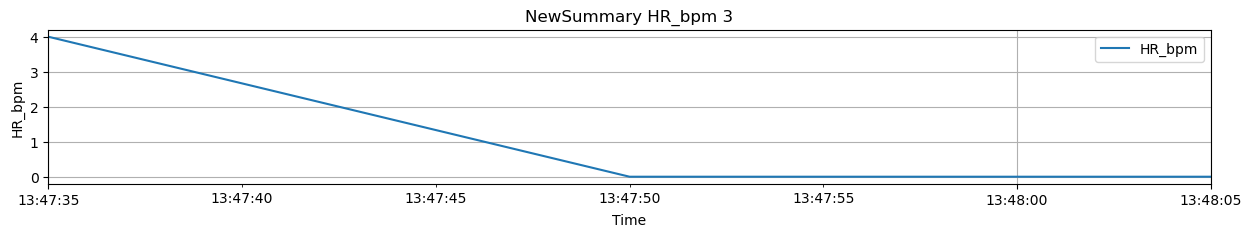

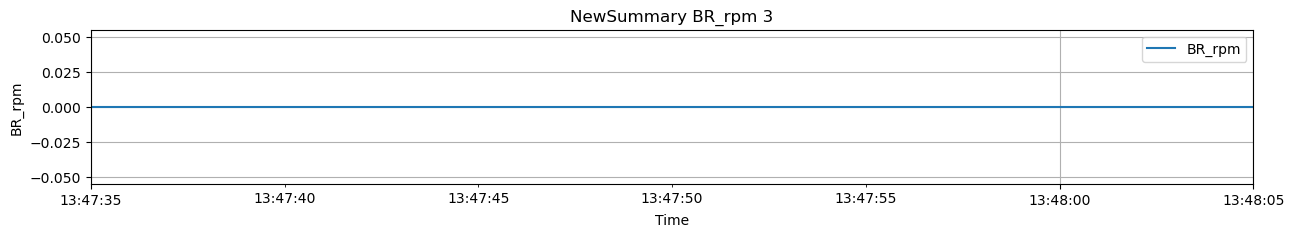

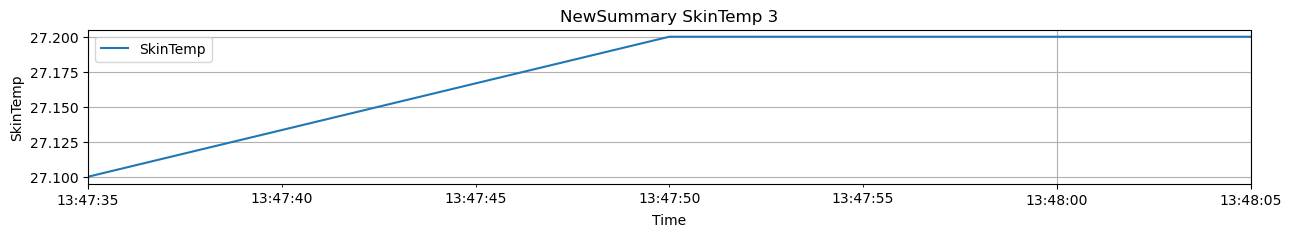



NewSummary C:\Users\fourMs lab\Documents\Equivital\Equivital Manager\03420415\23011803_NewSummary.csv
Date (M/d/yyyy)                                1/18/2023
Time (HH:mm:ss)                                 13:47:35
Sensor ID                                        3420415
SEM File Designation                      FactoryDefault
HR (bpm)                                               4
BR (rpm)                                               0
Skin Temperature - IR Thermometer (°C)              27.1
Body Position                                       Side
Ambulation Status                             Stationary
Alert                                               Blue
PWI                                                 Blue
Device Indications                                     Y
Subject Indications                                    Y
Name: 0, dtype: object
Index(['HR_bpm', 'BR_rpm', 'SkinTemp', 'Posture', 'Ambulation'], dtype='object')
                     HR_bpm  BR_rpm  SkinTemp Postu

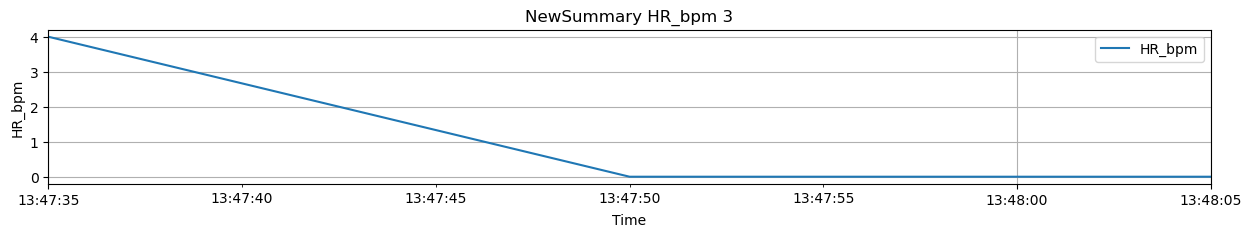

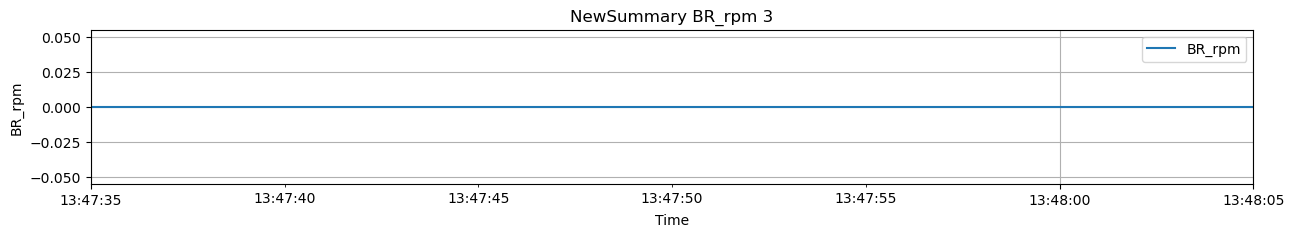

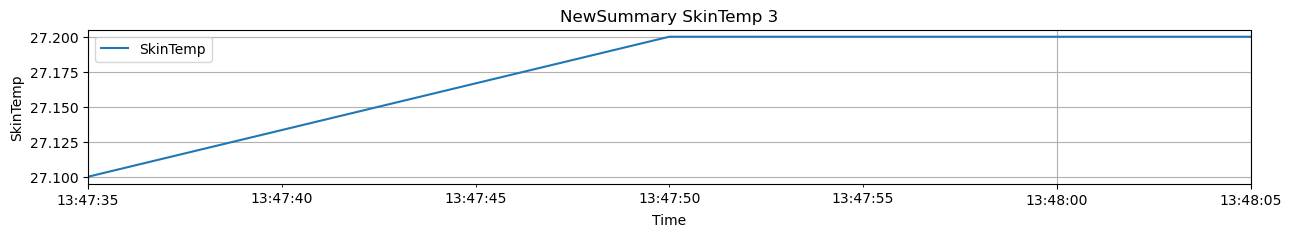

In [69]:
# make an initial reading of files in file subset to show contents formating

for c,row in sub_files.iloc[1:3,:].iterrows():
    print('\n')
    print(row['Signal'] + ' ' + row['FullLoc'])  
 #   df =pd.read_csv(row['FullLoc'],header=0,low_memory=False)
    sig_df = eq_file_exct(row['FullLoc'])
    if not sig_df.empty:
        s = row['Signal']
        print(sig_df.columns)
        t = int(len(sig_df)/2) # grab signal from the middle of the recording, when it was being worn
        print(sig_df.iloc[t:t+3,:])
        for c in sig_df.columns:
            if sig_df[c].dtype in ['int64','float64']:
                sig_df.plot(y = c,figsize=(15,2))
                plt.xlabel('Time')
                plt.ylabel(c)
                plt.grid()
                plt.title(s + ' ' + c + ' ' + row['Session'])
                plt.show()

In [67]:
# make an initial reading of files in file subset to show contents formating

for c,row in sub_files.iterrows():
    print('\n')
    print(row['Signal'] + ' ' + row['FullLoc'])  
 #   df =pd.read_csv(row['FullLoc'],header=0,low_memory=False)
    V = pd.read_csv(row['FullLoc'],skipinitialspace=True)
    print(V['Button Press Event'])



Indications C:\Users\fourMs lab\Documents\Equivital\Equivital Manager\03420415\23011802_Indications.csv
0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
      ... 
167    NaN
168    NaN
169    NaN
170    NaN
171    NaN
Name: Button Press Event, Length: 172, dtype: object


Indications C:\Users\fourMs lab\Documents\Equivital\Equivital Manager\03420415\23011803_Indications(0).csv
0   NaN
1   NaN
2   NaN
Name: Button Press Event, dtype: float64


Indications C:\Users\fourMs lab\Documents\Equivital\Equivital Manager\03420415\23011803_Indications.csv
0   NaN
1   NaN
2   NaN
Name: Button Press Event, dtype: float64


Indications C:\Users\fourMs lab\Documents\Equivital\Equivital Manager\03420415\23011900_Indications(0).csv
0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
3021   NaN
3022   NaN
3023   NaN
3024   NaN
3025   NaN
Name: Button Press Event, Length: 3026, dtype: float64


Indications C:\Users\fourMs lab\Documents\Equivital\Equivital Manager\03420415\23011900_

In [98]:
sig_num = sig_df.select_dtypes(include=['int64','float64'])

In [70]:
len(df.loc[0,'Date (M/d/yyyy)'])

27

In [43]:
sig_df

,HR_bpm,BR_rpm,SkinTemp,Posture,Ambulation
Time,,,,,
2023-01-20 16:06:25,0,NaN,27.5,Side,Stationary
2023-01-20 16:06:30,0,1.0,27.5,Side,Stationary
2023-01-20 16:06:35,0,1.0,24.3,Side,Stationary
2023-01-20 16:06:40,0,1.0,24.3,Side,Stationary
2023-01-20 16:06:45,0,1.0,24.3,Side,Stationary
...,...,...,...,...,...
2023-01-21 07:30:10,0,0.0,22.4,Side,Stationary
2023-01-21 07:30:15,0,0.0,22.4,Side,Stationary
2023-01-21 07:30:20,0,0.0,22.4,Side,Stationary


# Plot sensor readings for specific interval of time

These run through files and plot their out puts within specific ranges of time


In [101]:
# if a single interval  
# notice no date specified, to match reading of these files
trial_times = pd.to_datetime(['2023-01-21 03:45:36.367','2023-01-21 03:55:36'])
# # and time stamps for markers of events (approx)

# trial_ends = pd.to_datetime(['13:24:00','13:30:09','13:38:34','13:43:27'])

Index(['Breathing Wave'], dtype='object')


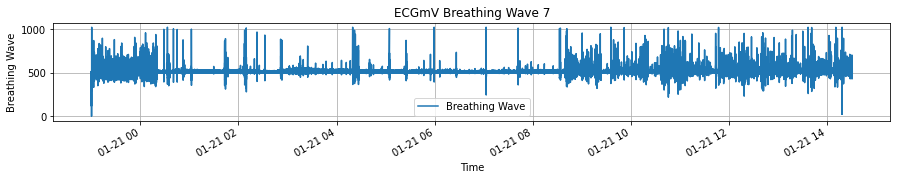

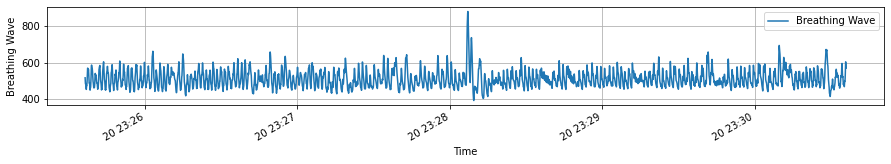

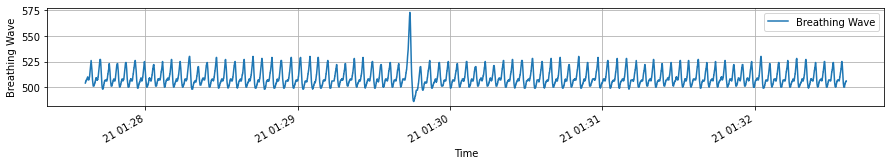

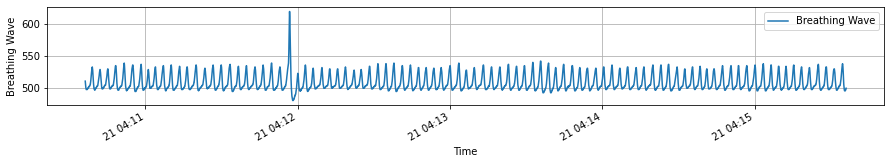

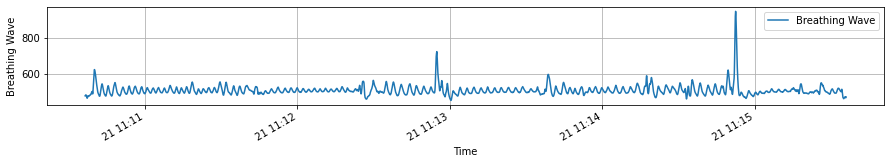

In [119]:
# plot the all the subfiles on the same region of time
datafile_type = 'Belt'
signal_interest = 'Breathing Wave'

#   df =pd.read_csv(row['FullLoc'],header=0,low_memory=False)
sig_df = eq_file_exct('./Battery_tests/23012007_Belt.csv')
print(sig_df.columns)
sig_df.plot(y = signal_interest,figsize=(15,2))
plt.xlabel('Time')
plt.ylabel(c)
plt.grid()
plt.title(s + ' ' + c + ' ' + row['Session'])
plt.show()

trial_times = pd.to_datetime(['2023-01-20 23:25:36.367','2023-01-20 23:30:36'])
a = sig_df.loc[trial_times[0]:trial_times[1]]
a.plot(figsize=(15,2))
d =a.std()
plt.ylabel(signal_interest)
plt.grid()
plt.show()

trial_times = pd.to_datetime(['2023-01-21 01:27:36.367','2023-01-21 01:32:36'])
a = sig_df.loc[trial_times[0]:trial_times[1]]
a.plot(figsize=(15,2))
d =a.std()
plt.ylabel(signal_interest)
plt.grid()
plt.show()

trial_times = pd.to_datetime(['2023-01-21 04:10:36.367','2023-01-21 04:15:36'])
a = sig_df.loc[trial_times[0]:trial_times[1]]
a.plot(figsize=(15,2))
d =a.std()
plt.ylabel(signal_interest)
plt.grid()
plt.show()

trial_times = pd.to_datetime(['2023-01-21 11:10:36.367','2023-01-21 11:15:36'])
a = sig_df.loc[trial_times[0]:trial_times[1]]
a.plot(figsize=(15,2))
d =a.std()
plt.ylabel(signal_interest)
plt.grid()
plt.show()

Index(['ECG Lead 1', 'ECG Lead 2'], dtype='object')


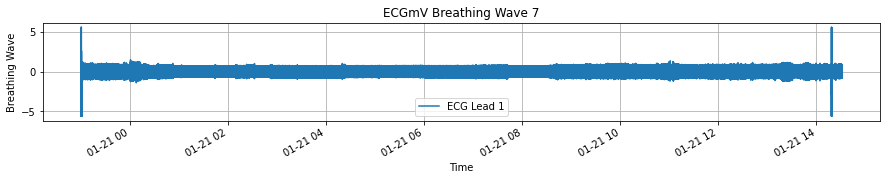

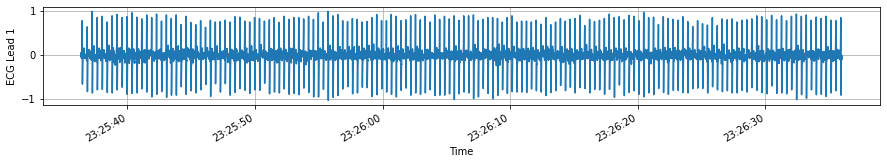

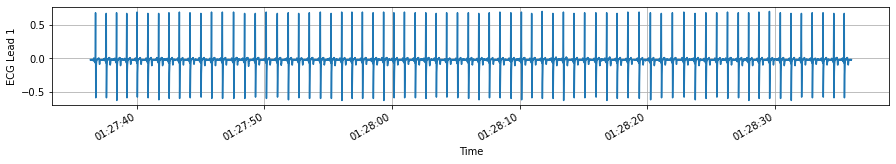

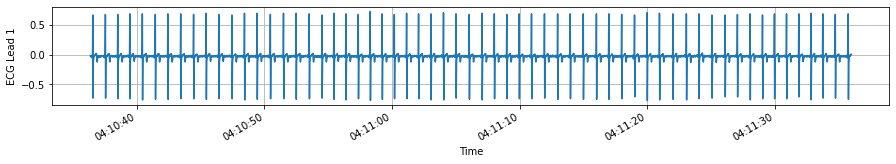

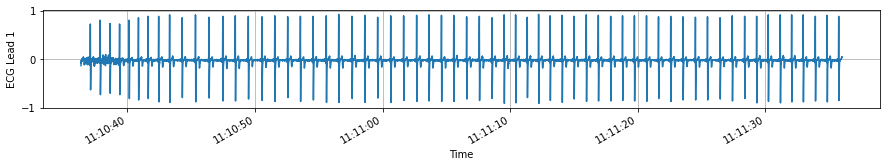

In [113]:
# plot the all the subfiles on the same region of time

signal_interest = 'ECG Lead 1'
#   df =pd.read_csv(row['FullLoc'],header=0,low_memory=False)
sig_df = eq_file_exct('./Battery_tests/23012007_ECGmV.csv')
print(sig_df.columns)
sig_df.plot(y = signal_interest,figsize=(15,2))
plt.xlabel('Time')
plt.ylabel(c)
plt.grid()
plt.title(s + ' ' + c + ' ' + row['Session'])
plt.show()

trial_times = pd.to_datetime(['2023-01-20 23:25:36.367','2023-01-20 23:26:36'])
a = sig_df.loc[trial_times[0]:trial_times[1],signal_interest]
a.plot(figsize=(15,2))
d =a.std()
plt.ylabel(signal_interest)
plt.grid()
plt.show()

trial_times = pd.to_datetime(['2023-01-21 01:27:36.367','2023-01-21 01:28:36'])
a = sig_df.loc[trial_times[0]:trial_times[1],signal_interest]
a.plot(figsize=(15,2))
d =a.std()
plt.ylabel(signal_interest)
plt.grid()
plt.show()

trial_times = pd.to_datetime(['2023-01-21 04:10:36.367','2023-01-21 04:11:36'])
a = sig_df.loc[trial_times[0]:trial_times[1],signal_interest]
a.plot(figsize=(15,2))
d =a.std()
plt.ylabel(signal_interest)
plt.grid()
plt.show()

trial_times = pd.to_datetime(['2023-01-21 11:10:36.367','2023-01-21 11:11:36'])
a = sig_df.loc[trial_times[0]:trial_times[1],signal_interest]
a.plot(figsize=(15,2))
d =a.std()
plt.ylabel(signal_interest)
plt.grid()
plt.show()

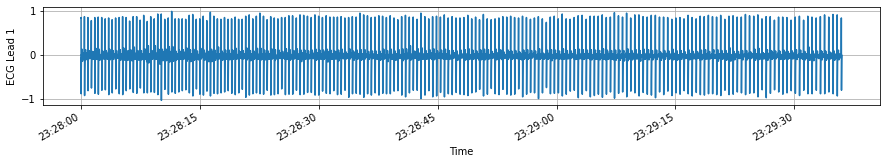

In [116]:
trial_times = pd.to_datetime(['2023-01-20 23:28:00.0','2023-01-20 23:29:36'])
a = sig_df.loc[trial_times[0]:trial_times[1],signal_interest]
a.plot(figsize=(15,2))
d =a.std()
plt.ylabel(signal_interest)
plt.grid()
plt.show()

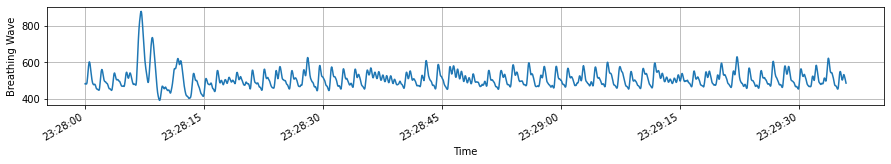

In [120]:
trial_times = pd.to_datetime(['2023-01-20 23:28:00.0','2023-01-20 23:29:36'])
a = sig_df.loc[trial_times[0]:trial_times[1],signal_interest]
a.plot(figsize=(15,2))
d =a.std()
plt.ylabel(signal_interest)
plt.grid()
plt.show()

In [104]:
sig_df

,ECG Lead 1,ECG Lead 2
Time,,
2023-01-20 22:59:59.003,-5.19,-5.19
2023-01-20 22:59:59.007,-5.19,-5.19
2023-01-20 22:59:59.011,-5.19,-5.19
2023-01-20 22:59:59.015,-5.19,-5.19
2023-01-20 22:59:59.019,-5.19,-5.19
...,...,...
2023-01-21 14:31:13.710,0.00,-0.02
2023-01-21 14:31:13.714,0.00,-0.02
2023-01-21 14:31:13.718,-0.03,-0.02
